In [1]:
from utils.plot_utils import get_numeric_template
import pickle as pkl
import numpy as np
import os
import pandas as pd
import pathlib
import glob
import seaborn as sns
from itertools import compress
import matplotlib.pyplot as plt
from collections import Counter
from scipy.signal import savgol_filter, resample

In [8]:
def plot_cam_template(file_name, plot_noisy, noise_levels_to_remove=None):
    if noise_levels_to_remove is None:
        noise_levels_to_remove = []

    with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), 'saved_models', file_name, f'figure_data_noise=0.0.pkl'), 'rb') as h:
        save_data = pkl.load(h)
    
    total_mean_activation = save_data['total_mean_activation']
    total_activation_std = save_data['total_activation_std']
    templates = save_data['cam_mat']
    templates_sig = save_data['sig_mat']
    before = save_data['before']
    after = save_data['after']
    num_rpeaks = save_data['cam_mat'].shape[1]
    if not plot_noisy:
        get_numeric_template(templates, before=before, fs=90)
        print(f'total activation mean: {total_mean_activation:.2f}, total activation std: {total_activation_std:.5f}')
        print(f'Averaged over {num_rpeaks} detections')

    templates_ts = np.linspace(-before*1000, after*1000, templates.shape[0], endpoint=False)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    mean_cam = np.mean(templates, axis=1)
    mean_cam = savgol_filter(mean_cam, 11, 2)
    
    sns.lineplot(x=templates_ts, y=mean_cam, color='k', label='CAM')
    
    if not plot_noisy and templates_sig is not None:
        mean_sig = .5*np.mean(templates_sig, axis=1)+0.2
        ax.plot(templates_ts, mean_sig, 'grey', linewidth=5, alpha=0.5, label='ECG')

    
    if plot_noisy:
        # get lists of noisy templates: valid (noise > 0) and sorted (for the coloring to be meaningful)
        list_of_noise_files = glob.glob(os.path.join(os.path.dirname(os.path.realpath(__file__)), 'saved_models', file_name, f'figure_data_noise=*'))
        list_of_noise_levels_all = [float(file.split('noise=')[1].split('.pkl')[0]) for file in list_of_noise_files]
        list_of_noise_levels_valid = list(filter(lambda x: x > 0, list_of_noise_levels_all))
        list_of_noise_levels_valid = list(filter(lambda x: x not in noise_levels_to_remove, list_of_noise_levels_valid))
        valid_idx = np.array([list_of_noise_levels_all[i] in list_of_noise_levels_valid for i in range(len(list_of_noise_levels_all))])
        list_of_noise_files_valid = list(compress(list_of_noise_files, valid_idx))
        list_of_noise_files_valid = [list_of_noise_files_valid[i] for i in np.argsort(list_of_noise_levels_valid)]
        list_of_noise_levels_valid = np.sort(list_of_noise_levels_valid)
        pal = sns.cubehelix_palette(len(list_of_noise_levels_valid), reverse=True)

        for i_noise, noise in enumerate(list_of_noise_levels_valid):
            with open(list_of_noise_files_valid[i_noise], 'rb') as h:
                save_data_noise = pkl.load(h)
            mean_cam_noise = np.mean(save_data_noise['cam_mat'], axis=1) 
            sns.lineplot(x=templates_ts, y=mean_cam_noise, label=noise, color=pal[i_noise])
            
    ax.set_xlabel('Time [ms]', fontsize=25)
    ax.set_ylabel('Amplitude [ms]', fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

#     plt.axvline(0, color='red', linestyle='--')
    
    # plot p-wave window
    ax.axvspan(-250, -100, alpha=0.3, color='xkcd:medium purple')
    ax.text(x=-175, y=0.6, s='P-Wave\n Window', horizontalalignment='center', rotation='vertical',
            verticalalignment='center' , fontsize=14)

    # plot QRS window
    ax.axvspan(-100, 0, alpha=0.3, color='teal')
    ax.text(x=-50, y=0.6, s='QR Interval', horizontalalignment='center', rotation='vertical',
            verticalalignment='center', fontsize=14)
    
    ax.set_ylim([0, 0.8])
    plt.grid()
    plt.legend(prop={'size': 25})
    plt.show()
    
    return fig



## Baseline

Accuracy: 89.82
F1 AF: 0.895
F1 NAF: 0.901
R2 rr: 0.513
R2 pwave: 0.094

Rep2Label Accuracy: 94.84
Rep2Label F1 AF: 0.72
Rep2Label F1 NAF: 0.97

mean_pwave: 0.31, pwave std: 0.00152
qr_mean: 0.14, qr std: 0.00119
rs_mean: 0.12, qr std: 0.00092
st_mean: 0.20, qr std: 0.00089
qrs_mean: 0.13, qr std: 0.00074
total activation mean: 0.23, total activation std: 0.00111
Averaged over 3839 detections


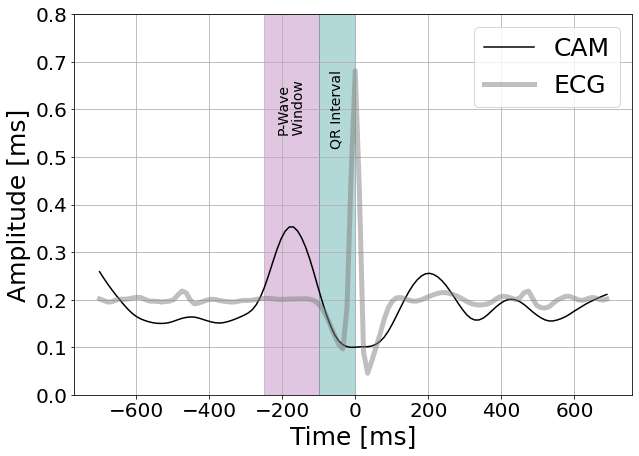

In [10]:
file_name = 'BaselineDS_balanced_naf'
with open(f'saved_models/{file_name}/{file_name}_test_res.pkl', 'rb') as f:
    baseline_test_res = pkl.load(f)
with open(f'saved_models/{file_name}/{file_name}_test_r2_rr_included_fixed.pkl', 'rb') as f:
    baseline_r2_rr = pkl.load(f)
with open(f'saved_models/{file_name}/{file_name}_test_r2_p_wave_excluded_fixed.pkl', 'rb') as f:
    baseline_r2_pwave = pkl.load(f)
with open(f'saved_models/{file_name}/{file_name}_rep2label_perf.pkl', 'rb') as f:
    rep2label_perf = pkl.load(f)
    
rep2label_acc = np.mean([rep2label_perf[i]['accuracy'] for i in range(5)])
rep2label_F1_NAF = np.mean([rep2label_perf[i]['f1_normal'] for i in range(5)])
rep2label_F1_AF = np.mean([rep2label_perf[i]['f1_af'] for i in range(5)])
baseline_acc    = baseline_test_res['accuracy']
baseline_F1_NAF = baseline_test_res['f1_normal']
baseline_F1_AF  = baseline_test_res['f1_af']

print(f'Accuracy: {baseline_acc:.2f}')
print(f'F1 AF: {baseline_F1_AF:.3f}')
print(f'F1 NAF: {baseline_F1_NAF:.3f}')
print(f'R2 rr: {baseline_r2_rr:.3f}')
print(f'R2 pwave: {baseline_r2_pwave:.3f}')
print("")
print(f'Rep2Label Accuracy: {rep2label_acc:.2f}')
print(f'Rep2Label F1 AF: {rep2label_F1_AF:.2f}')
print(f'Rep2Label F1 NAF: {rep2label_F1_NAF:.2f}')
print("")

plot_noisy = False
fig=plot_cam_template(file_name=file_name,plot_noisy=plot_noisy);
suffix = '_noise' if plot_noisy else ''
fig.savefig(f'Figures/Baseline{suffix}.png', dpi=500)

## RR model

Accuracy: 94.51
F1 AF: 0.947
F1 NAF: 0.943
R2 rr: -0.009
R2 pwave: -0.053

Rep2Label Accuracy: 54.84
Rep2Label F1 AF: 0.36
Rep2Label F1 NAF: 0.49

Accuracy from RR features: 94.26

mean_pwave: 0.30, pwave std: 0.00138
qr_mean: 0.16, qr std: 0.00110
rs_mean: 0.16, qr std: 0.00099
st_mean: 0.21, qr std: 0.00082
qrs_mean: 0.16, qr std: 0.00074
total activation mean: 0.00, total activation std: 0.00004
Averaged over 3839 detections


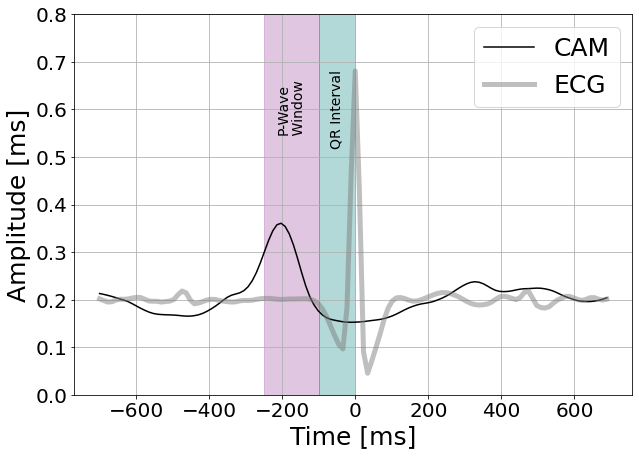

In [11]:
file_name = 'lambda_500_rr_balanced_NAF'
with open(f'saved_models/{file_name}/{file_name}_test_res.pkl', 'rb') as f:
    rr_test_res = pkl.load(f)
with open(f'saved_models/{file_name}/{file_name}_test_r2_rr_included_fixed.pkl', 'rb') as f:
    rr_r2_rr = pkl.load(f)
with open(f'saved_models/{file_name}/{file_name}_test_r2_p_wave_excluded_fixed.pkl', 'rb') as f:
    rr_r2_pwave = pkl.load(f)
with open(f'saved_models/{file_name}/{file_name}_rep2label_perf.pkl', 'rb') as f:
    rep2label_perf = pkl.load(f)
with open(f'saved_models/rr_features_to_labels_NAF_perf.pkl', 'rb') as f:
    features_to_labels = pkl.load(f)
    
rep2label_acc = np.mean([rep2label_perf[i]['accuracy'] for i in range(5)])
rep2label_F1_NAF = np.mean([rep2label_perf[i]['f1_normal'] for i in range(5)])
rep2label_F1_AF = np.mean([rep2label_perf[i]['f1_af'] for i in range(5)])
    
rr_acc    = rr_test_res['accuracy']
rr_F1_NAF = rr_test_res['f1_normal']
rr_F1_AF  = rr_test_res['f1_af']
acc_rr_features = features_to_labels['accuracy']
print(f'Accuracy: {rr_acc:.2f}')
print(f'F1 AF: {rr_F1_AF:.3f}')
print(f'F1 NAF: {rr_F1_NAF:.3f}')
print(f'R2 rr: {rr_r2_rr:.3f}')
print(f'R2 pwave: {rr_r2_pwave:.3f}')
print("")
print(f'Rep2Label Accuracy: {rep2label_acc:.2f}')
print(f'Rep2Label F1 AF: {rep2label_F1_AF:.2f}')
print(f'Rep2Label F1 NAF: {rep2label_F1_NAF:.2f}')
print("")
print(f'Accuracy from RR features: {acc_rr_features:.2f}')
print("")

plot_noisy = False
fig = plot_cam_template(file_name=file_name,plot_noisy=plot_noisy)
suffix = '_noise' if plot_noisy else ''
fig.savefig(f'Figures/RR{suffix}.png', dpi=500)

## P-Wave

Accuracy: 89.74
F1 AF: 0.890
F1 NAF: 0.904
R2 rr: -0.032
R2 pwave: -0.082

Rep2Label Accuracy: 57.90
Rep2Label F1 AF: 0.45
Rep2Label F1 NAF: 0.59

Accuracy from P-Wave features: 87.32

mean_pwave: 0.26, pwave std: 0.00128
qr_mean: 0.29, qr std: 0.00170
rs_mean: 0.12, qr std: 0.00078
st_mean: 0.16, qr std: 0.00069
qrs_mean: 0.20, qr std: 0.00093
total activation mean: 0.01, total activation std: 0.00006
Averaged over 3839 detections


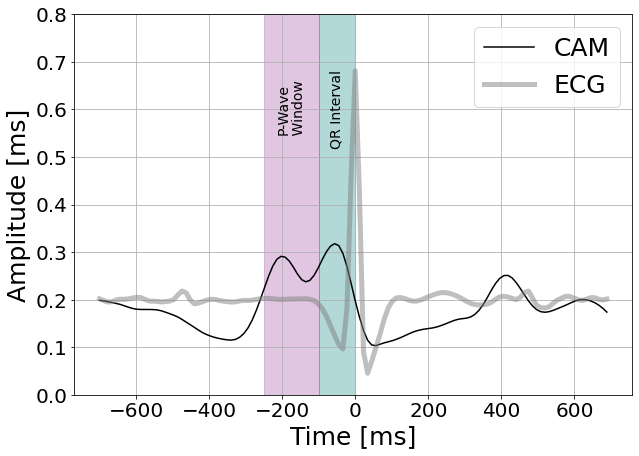

In [12]:
file_name = 'lambda_500_pwave_naf'
with open(f'saved_models/{file_name}/{file_name}_test_res.pkl', 'rb') as f:
    pwave_test_res = pkl.load(f)
with open(f'saved_models/{file_name}/{file_name}_test_r2_rr_excluded_fixed.pkl', 'rb') as f:
    pwave_r2_rr = pkl.load(f)
with open(f'saved_models/{file_name}/{file_name}_test_r2_p_wave_included_fixed.pkl', 'rb') as f:
    pwave_r2_pwave = pkl.load(f)
with open(f'saved_models/{file_name}/{file_name}_rep2label_perf.pkl', 'rb') as f:
    rep2label_perf = pkl.load(f)
with open(f'saved_models/p_wave_features_to_labels_NAF_perf.pkl', 'rb') as f:
    features_to_labels = pkl.load(f)
    
rep2label_acc = np.mean([rep2label_perf[i]['accuracy'] for i in range(5)])
rep2label_F1_NAF = np.mean([rep2label_perf[i]['f1_normal'] for i in range(5)])
rep2label_F1_AF = np.mean([rep2label_perf[i]['f1_af'] for i in range(5)])
    
pwave_acc    = pwave_test_res['accuracy']
pwave_F1_NAF = pwave_test_res['f1_normal']
pwave_F1_AF  = pwave_test_res['f1_af']
acc_pwave_features = features_to_labels['accuracy']

print(f'Accuracy: {pwave_acc:.2f}')
print(f'F1 AF: {pwave_F1_AF:.3f}')
print(f'F1 NAF: {pwave_F1_NAF:.3f}')
print(f'R2 rr: {pwave_r2_rr:.3f}')
print(f'R2 pwave: {pwave_r2_pwave:.3f}')
print("")
print(f'Rep2Label Accuracy: {rep2label_acc:.2f}')
print(f'Rep2Label F1 AF: {rep2label_F1_AF:.2f}')
print(f'Rep2Label F1 NAF: {rep2label_F1_NAF:.2f}')
print("")
print(f'Accuracy from P-Wave features: {acc_pwave_features:.2f}')
print("")

plot_noisy = False
fig = plot_cam_template(file_name=file_name,plot_noisy=plot_noisy)
suffix = '_noise' if plot_noisy else ''
fig.savefig(f'Figures/PWave{suffix}.png', dpi=500)

## ALL

Accuracy: 92.08
F1 AF: 0.915
F1 NAF: 0.926
R2 rr: -0.032
R2 pwave: -0.055

Rep2Label Accuracy: 51.77
Rep2Label F1 AF: 0.15
Rep2Label F1 NAF: 0.54

Accuracy from all features: 95.56

mean_pwave: 0.36, pwave std: 0.00126
qr_mean: 0.38, qr std: 0.00154
rs_mean: 0.33, qr std: 0.00131
st_mean: 0.33, qr std: 0.00089
qrs_mean: 0.35, qr std: 0.00101
total activation mean: 0.00, total activation std: 0.00005
Averaged over 3839 detections


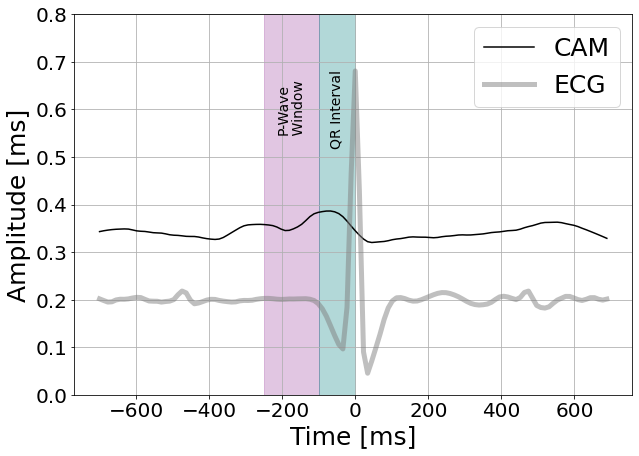

In [13]:
file_name = 'lambda_500_all_naf'
with open(f'saved_models/{file_name}/{file_name}_test_res.pkl', 'rb') as f:
    all_test_res = pkl.load(f)
with open(f'saved_models/{file_name}/{file_name}_test_r2_rr_included_fixed.pkl', 'rb') as f:
    all_r2_rr = pkl.load(f)
with open(f'saved_models/{file_name}/{file_name}_test_r2_p_wave_excluded_fixed.pkl', 'rb') as f:
    all_r2_pwave = pkl.load(f)
with open(f'saved_models/{file_name}/{file_name}_rep2label_perf.pkl', 'rb') as f:
    rep2label_perf = pkl.load(f)
with open(f'saved_models/all_features_to_labels_NAF_perf.pkl', 'rb') as f:
    features_to_labels = pkl.load(f)
    
rep2label_acc = np.mean([rep2label_perf[i]['accuracy'] for i in range(5)])
rep2label_F1_NAF = np.mean([rep2label_perf[i]['f1_normal'] for i in range(5)])
rep2label_F1_AF = np.mean([rep2label_perf[i]['f1_af'] for i in range(5)])
    
all_acc    = all_test_res['accuracy']
all_F1_NAF = all_test_res['f1_normal']
all_F1_AF  = all_test_res['f1_af']
all_pwave_features = features_to_labels['accuracy']

print(f'Accuracy: {all_acc:.2f}')
print(f'F1 AF: {all_F1_AF:.3f}')
print(f'F1 NAF: {all_F1_NAF:.3f}')
print(f'R2 rr: {all_r2_rr:.3f}')
print(f'R2 pwave: {all_r2_pwave:.3f}')
print("")
print(f'Rep2Label Accuracy: {rep2label_acc:.2f}')
print(f'Rep2Label F1 AF: {rep2label_F1_AF:.2f}')
print(f'Rep2Label F1 NAF: {rep2label_F1_NAF:.2f}')
print("")
print(f'Accuracy from all features: {all_pwave_features:.2f}')
print("")

plot_noisy = False
fig = plot_cam_template(file_name=file_name,plot_noisy=plot_noisy)
suffix = '_noise' if plot_noisy else ''
fig.savefig(f'Figures/All{suffix}.png', dpi=500)

### Peak location statistical analysis

In [16]:
with open(os.path.join(os.getcwd(), os.path.dirname(os.path.realpath(__file__)), 'lambda_500_rr_balanced_NAF', f'figure_data_noise=0.0_pval.pkl'), 'rb') as h:
    rr_data = pkl.load(h)
with open(os.path.join(os.getcwd(), os.path.dirname(os.path.realpath(__file__)), 'lambda_500_pwave_naf', f'figure_data_noise=0.0_pval.pkl'), 'rb') as h:
    pwave_data = pkl.load(h)
    
with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), 'saved_models', 'BaselineDS_balanced_naf', f'figure_data_noise=0.0.pkl'), 'rb') as h:
    baseline_data = pkl.load(h)


In [17]:
np.array_equal(pwave_data['list_signal_names'], rr_data['list_signal_names'])

True

In [18]:
from scipy.signal import find_peaks
# np.array([find_peaks(rr_data['cam_mat'][:,i]) for i in range(rr_data['cam_mat'].shape[0])])
rr_locs = np.argmax(rr_data['cam_mat'], axis=0)
pwave_locs = np.argmax(pwave_data['cam_mat'], axis=0)
baseline_locs = np.argmax(baseline_data['cam_mat'], axis=0)

In [ ]:
sns.distplot(rr_locs, kde=False);
print(f'Mean = {rr_locs.mean()}')

In [ ]:
sns.distplot(pwave_locs, kde=False);
print(f'Mean = {pwave_locs.mean()}')

In [19]:
def get_numeric_template(cam_mat, before, fs=90):

    peak_loc = int(before*fs)
    pwave_start = peak_loc - int(0.25*fs)
    pwave_end = peak_loc - int(0.1*fs)
    s_peak = peak_loc + int(0.13*fs)
    t_peak_end = peak_loc + int(0.4*fs)

    pwave_activation = cam_mat[pwave_start:pwave_end, :].copy()
    qr_activation = cam_mat[pwave_end:peak_loc, :].copy()

    return pwave_activation, qr_activation

In [20]:
pwave_activation, qr_activation = get_numeric_template(pwave_data['cam_mat'], pwave_data['before'], fs=90)
pwave_pwave_activation = pwave_activation.flatten()
pwave_qr_activation = qr_activation.flatten()


pwave_activation, qr_activation = get_numeric_template(rr_data['cam_mat'], rr_data['before'], fs=90)
rr_pwave_activation = pwave_activation.flatten()
rr_qr_activation = qr_activation.flatten()

pwave_activation, qr_activation = get_numeric_template(baseline_data['cam_mat'], baseline_data['before'], fs=90)
baseline_pwave_activation = pwave_activation.flatten()
baseline_qr_activation = qr_activation.flatten()


In [ ]:
pwave_activation, qr_activation = get_numeric_template(rr_data['cam_mat'], rr_data['before'], fs=90)
rr_pwave_activation = pwave_activation.flatten()
rr_qr_activation = qr_activation.flatten()


In [26]:
from scipy.stats import ttest_rel
ttest_rel(rr_pwave_activation, baseline_pwave_activation)

Ttest_relResult(statistic=-3.8043476060929633, pvalue=0.00014234783399933885)

In [54]:
ttest_rel(rr_qr_activation, pwave_qr_activation)

Ttest_relResult(statistic=-65.35894482016563, pvalue=0.0)

In [50]:
pwave_pwave_activation.shape

(49907,)

In [52]:
pwave_activation.shape

(13, 3839)